In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from nltk.corpus import stopwords
import gensim
import xgboost, textblob, string
import re
import nltk
import string
import spacy
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from pprint import pprint
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
df = pd.read_csv('tripadvisor_reviews.csv', index_col='date', parse_dates=True)
# create sentiment labels
label = []
for i in df['rating']:
    if i <= 2:
        sent = 0
    else: 
        sent = 1
    label.append(sent)   
df['label'] = label

# process NAs 
df['title'] = df['title'].fillna(value=np.nan)

# lowerkey 
review_list = []
for i in df['review']: 
    i = i.lower()
    review_list.append(i)
df['review'] = review_list

df['title'] = df['title'].astype(str)
title_list = []
for j in df['title']:
    j = j.lower()
    title_list.append(j)
df['title'] = title_list

bad = pd.read_csv('Bad tour reviews.csv')
bad.columns = ['TourReviewID', 'TourID', 'Username', 'rating', 'review', 'date',
       'IsActive', 'title', 'Email']
bad_needed = bad[['date', 'title', 'review', 'rating']]

# create sentiment labels
blabel = []
for i in bad_needed['rating']:
    if i <= 2:
        sent = 0
    else: 
        sent = 1
    blabel.append(sent)   
bad_needed['label'] = blabel

bad_needed.to_csv('bad_reviews.csv')

In [2]:
df = pd.read_csv('tripadvisor.csv', index_col='date', parse_dates = True)
df.shape

(4259, 4)

In [3]:
pos = df[df['label']==1]
neg = df[df['label']==0]
pos.shape

(4173, 4)

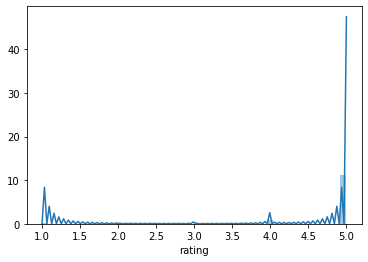

In [5]:
df['rating'].describe()
sns.distplot(df['rating'])

Text(0, 0.5, 'Rating')

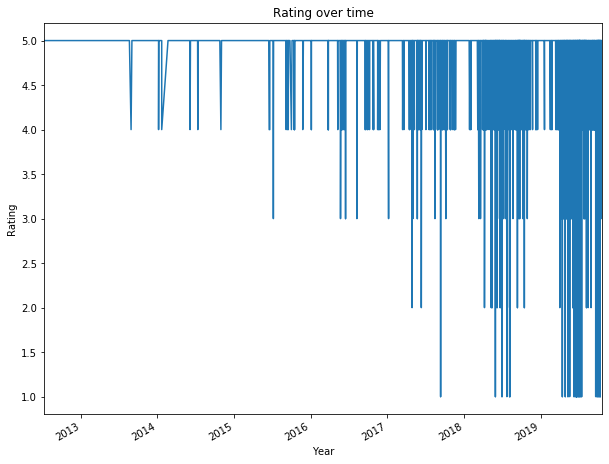

In [22]:
df['rating'].plot(figsize=(10, 8))
plt.xlabel('Year')
plt.title('Rating over time')
plt.ylabel('Rating')

Text(0.5, 0, 'Month')

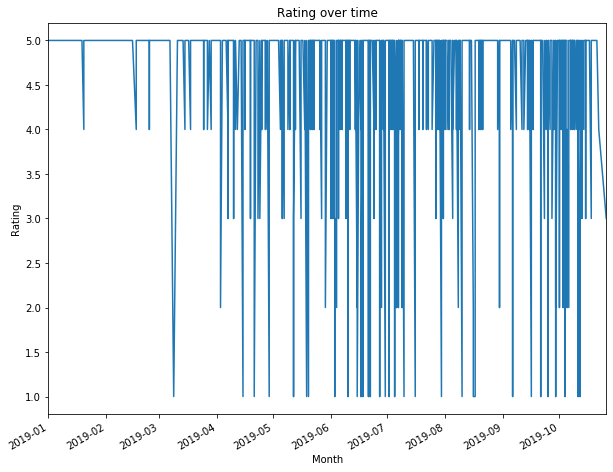

In [33]:
df['2019']['rating'].plot(figsize=(10, 8))
plt.title('Rating over time')
plt.ylabel('Rating')
plt.xlabel('Month')

5    3822
4     285
3      51
1      27
2      25
Name: rating, dtype: int64


Text(0.5, 0, 'Count')

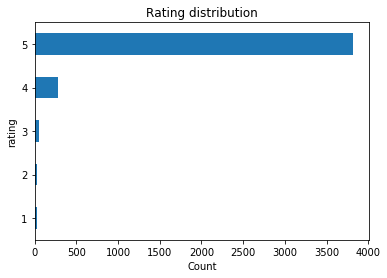

In [18]:
print(df['rating'].value_counts())
df.groupby(['rating']).size().plot(kind='barh')
plt.title('Rating distribution')
plt.xlabel('Count')

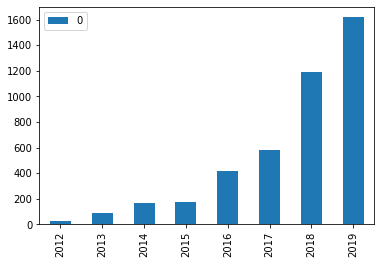

In [9]:
rv_count = []
years = []
for i in range(12, 20, 1):
    year = '20{}'.format(i)
    years.append(year)
    rv_amt = df[year].shape[0]
    rv_count.append(rv_amt)
    
tbl = pd.DataFrame(rv_count, years)
tbl.plot(kind='bar')

In [3]:
# remove stop words
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english') 
stop_words.extend(['tour', 'tours', 'guide', 'roman', 'guy', 'us', 'can', 'could', 'would', 'should', 'might', "won't", 
                   'was', 'must', 'is', "hasn't", "aren't", "are", "ain't", "isn't", 'recommend'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bichn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['serena', 'great', 'informative', 'complaint', 'nothing', 'serena', 'venue', 'many', 'photos', 'colosseum']


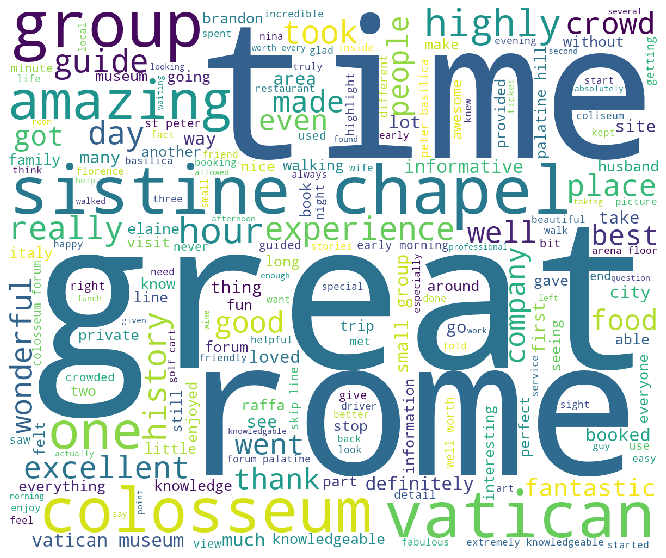

In [9]:
text = nltk.word_tokenize(" ".join(df['review'].tolist()))
cleanwords = [i for i in text if i not in stop_words and i.isalpha()]
print(cleanwords[:10])

# prep the wordcloud
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000).generate(" ".join(cleanwords))

# plot
fig_custom = plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

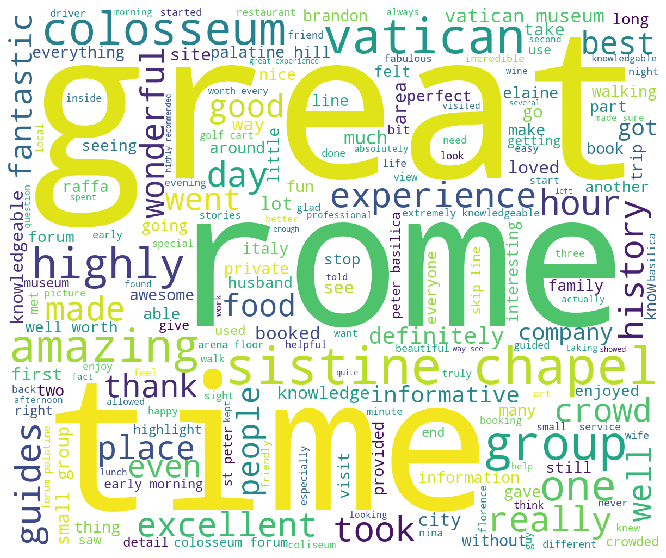

In [10]:
# wordcloud for negative reviews
neg = df[df['label']==1]
text_neg = nltk.word_tokenize(" ".join(neg['review'].tolist()))
cleanwords_neg = [i for i in text_neg if i not in stop_words and i.isalpha()]
wordcloud_neg = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000).generate(" ".join(cleanwords_neg))

fig_custom = plt.figure(figsize = (20, 10))
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.show()

['serena', 'great', 'informative', 'complaint', 'serena', 'many', 'photo', 'colosseum', 'hour', 'difficult']


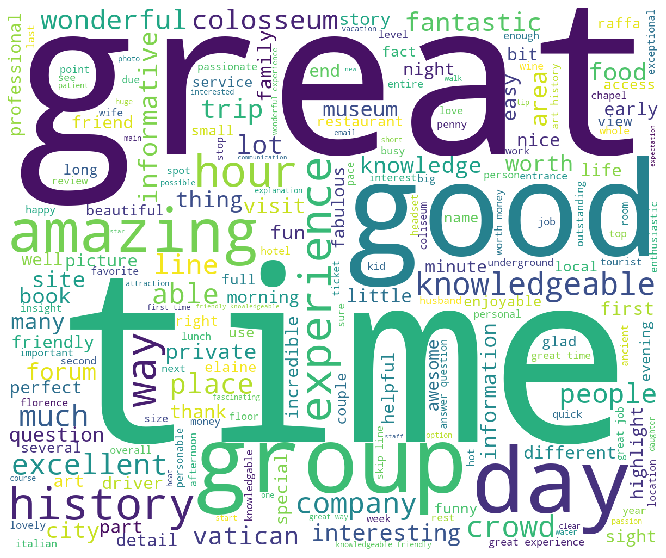

In [37]:
text_pos = []
for i in data_lemmatized:
    for j in i: 
        text_pos.append(j)
        
cleanwords = [i for i in text_pos if i not in stop_words and i.isalpha()]
print(cleanwords[:10])

# prep the wordcloud
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000).generate(" ".join(cleanwords))

# plot
fig_custom = plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

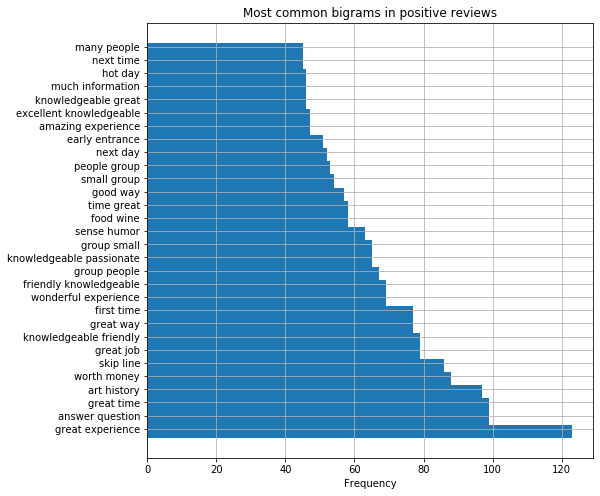

In [43]:
# positive reviews' bigrams
from collections import Counter
#text_pos = nltk.word_tokenize(" ".join(pos['review'].tolist()))
cleanwords_pos = [i for i in text_pos if i not in stop_words and i.isalpha()]
bigrams_pos = nltk.bigrams(cleanwords_pos)
counter_pos = Counter(bigrams_pos)
most_common_pos = sorted(counter_pos.most_common(30), key = lambda x: x[1], reverse=True)
labels = [" ".join(e[0]) for e in most_common_pos]
values = [e[1] for e in most_common_pos]
indexes = np.arange(len(labels))
width = 1
bigrams_fig = plt.figure(figsize = (8, 8))
plt.barh(indexes, values, width)

plt.yticks(indexes + width * 0.2, labels)
plt.title('Most common bigrams in positive reviews')
plt.xlabel('Frequency')
plt.grid()
plt.show()

# Topic modeling

In [7]:
# tokenize and clean
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuation

data_words = list(sent_to_words(pos['review']))
print(data_words[4000])

['what', 'wonderful', 'experience', 'brandon', 'must', 'hand', 'pick', 'each', 'of', 'his', 'guides', 'they', 'were', 'all', 'passionate', 'knowledgeable', 'and', 'fun', 'our', 'favorites', 'were', 'ava', 'and', 'nina', 'we', 'brought', 'our', 'three', 'girls', 'and', 'and', 'they', 'were', 'completed', 'engaged', 'in', 'each', 'tour', 'recommend', 'to', 'definitely', 'do', 'all', 'three', 'if', 'only', 'we', 'could', 'get', 'the', 'roman', 'guys', 'to', 'go', 'to', 'our', 'next', 'big', 'trip']


pos_new = pos.copy()
pos_new['tokens'] = data_words
pos_new.to_csv('tokenized_tripadvisor.csv')

In [8]:
# Bigram and trigram models 
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=30) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(bigram_mod[data_words[1]])

['serena', 'was', 'an', 'exceptional', 'guide', 'for', 'this', 'tour', 'very', 'knowledgable', 'and', 'sense', 'of', 'humour', 'this', 'was', 'great', 'finish', 'to', 'our', 'month', 'in', 'italy', 'and', 'would', 'thoroughly', 'recommend', 'to', 'anyone_wanting', 'to', 'avoid', 'the', 'crowds', 'and', 'learn', 'about', 'some', 'spectacular', 'roman', 'history', 'andrew', 'and', 'fiona', 'australia']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ'])

print(data_lemmatized[:1])

[['serena', 'great', 'informative', 'complaint', 'serena', 'many', 'photo', 'colosseum', 'hour', 'difficult', 'various', 'vantage', 'point', 'quite_bit', 'many', 'stair', 'exercise', 'fault', 'keeper', 'poor', 'illumination', 'little', 'disappointing', 'nice', 'book', 'lucky', 'serena']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 3), (21, 1), (22, 1), (23, 1)]]


In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=1)

# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
optimal_x = x[coherence_values.index(max(coherence_values))]
plt.xlabel("Num Topics - Best is {}".format(optimal_x))
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

IndexError: index 2508 is out of bounds for axis 1 with size 2508

In [31]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=1,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [21]:
# Print the Keyword in the 10 topics
#pprint(lda_model_pos.print_topics())
#doc_lda = lda_model[corpus]

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.044653129285625

Coherence Score:  0.3754603203945104


In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=1,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


Perplexity:  -7.044653129285625

Coherence Score:  0.3754603203945104


C:\Users\bichn\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.401656 -0.105552       1        1  43.379383
5      0.089258  0.408011       2        1  14.790540
0      0.021136 -0.147943       3        1   9.931945
4     -0.027628 -0.101708       4        1   9.063071
3     -0.115267 -0.016496       5        1   8.828276
1     -0.121798 -0.027286       6        1   6.655547
7     -0.135706 -0.002561       7        1   4.882692
2     -0.111650 -0.006465       8        1   2.468551, topic_info=     Category         Freq             Term        Total  loglift  logprob
115   Default  1077.000000              day  1077.000000  30.0000  30.0000
61    Default  1913.000000             time  1913.000000  29.0000  29.0000
27    Default   950.000000          history   950.000000  28.0000  28.0000
7     Default  1829.000000            great  1829.000000  27.0000  27.0000
425   Default   736.000000             trip   736.000000  26.0000  26.0000
1     Default   593.000000        colosseum   593.000000  25.0000  25.0000
145   Default   522.000000        knowledge   522.000000  24.0000  24.0000
199   Default   493.000000            guide   493.000000  23.0000  23.0000
89    Default   433.000000             food   433.000000  22.0000  22.0000
79    Default   450.000000        fantastic   450.000000  21.0000  21.0000
104   Default   545.000000             city   545.000000  20.0000  20.0000
144   Default   417.000000      interesting   417.000000  19.0000  19.0000
341   Default   515.000000            place   515.000000  18.0000  18.0000
116   Default  1216.000000             good  1216.000000  17.0000  17.0000
121   Default   378.000000             area   378.000000  16.0000  16.0000
55    Default   374.000000            forum   374.000000  15.0000  15.0000
149   Default   423.000000          private   423.000000  14.0000  14.0000
109   Default   379.000000         question   379.000000  13.0000  13.0000
56    Default   972.000000            group   972.000000  12.0000  12.0000
188   Default   354.000000         friendly   354.000000  11.0000  11.0000
155   Default   913.000000              way   913.000000  10.0000  10.0000
138   Default   975.000000       experience   975.000000   9.0000   9.0000
33    Default   900.000000    knowledgeable   900.000000   8.0000   8.0000
216   Default   296.000000              art   296.000000   7.0000   7.0000
1116  Default   261.000000       restaurant   261.000000   6.0000   6.0000
269   Default   290.000000            small   290.000000   5.0000   5.0000
152   Default   249.000000            sight   249.000000   4.0000   4.0000
809   Default   260.000000            thank   260.000000   3.0000   3.0000
32    Default   765.000000          amazing   765.000000   2.0000   2.0000
93    Default   762.000000             much   762.000000   1.0000   1.0000
...       ...          ...              ...          ...      ...      ...
480    Topic8   156.364731            local   157.010513   3.6974  -2.5998
829    Topic8    75.661003         planning    76.308388   3.6930  -3.3258
237    Topic8    63.658482             shop    64.304344   3.6914  -3.4985
1085   Topic8    60.202549       come_alive    60.849079   3.6909  -3.5543
446    Topic8    56.592136           church    57.237892   3.6902  -3.6162
551    Topic8    54.758003     entertaining    55.403755   3.6898  -3.6491
1648   Topic8    53.699875         addition    54.346153   3.6896  -3.6686
227    Topic8    44.174160       difference    44.819962   3.6870  -3.8639
898    Topic8    41.770424          portion    42.417587   3.6862  -3.9199
915    Topic8    40.831081        impressed    41.477253   3.6858  -3.9426
770    Topic8    38.934708         pleasant    39.580441   3.6851  -3.9902
481    Topic8    38.904362      perspective    39.550282   3.6851  -3.9909
819    Topic8    38.748375           reason    39.394356   3.6850  -3.9950
1235   Topic8    38.000809    meeting_poin

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=1,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


Perplexity:  -6.862993954516134

Coherence Score:  0.5519644780889937


C:\Users\bichn\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.223396  0.209744       1        1  54.855137
0     -0.089148 -0.279842       2        1  32.637077
2      0.312544  0.070098       3        1  12.507783, topic_info=     Category         Freq                       Term        Total  loglift  \
425   Default   676.000000                       trip   676.000000  30.0000   
56    Default   964.000000                      group   964.000000  29.0000   
7     Default  1613.000000                      great  1613.000000  28.0000   
82    Default   703.000000             sistine_chapel   703.000000  27.0000   
78    Default   679.000000                       able   679.000000  26.0000   
126   Default   664.000000                     people   664.000000  25.0000   
149   Default   398.000000                    private   398.000000  24.0000   
8     Default   645.000000                       hour   645.000000  23.0000   
162   Default   570.000000                       line   570.000000  22.0000   
25    Default   507.000000                      crowd   507.000000  21.0000   
115   Default  1173.000000                        day  1173.000000  20.0000   
27    Default   907.000000                    history   907.000000  19.0000   
225   Default   471.000000                      worth   471.000000  18.0000   
116   Default  1074.000000                       good  1074.000000  17.0000   
215   Default   468.000000                    vatican   468.000000  16.0000   
216   Default   247.000000                        art   247.000000  15.0000   
138   Default   861.000000                 experience   861.000000  14.0000   
33    Default   794.000000              knowledgeable   794.000000  13.0000   
61    Default  1787.000000                       time  1787.000000  12.0000   
607   Default   193.000000                     driver   193.000000  11.0000   
32    Default   675.000000                    amazing   675.000000  10.0000   
169   Default   339.000000                      early   339.000000   9.0000   
224   Default   322.000000                      visit   322.000000   8.0000   
104   Default   595.000000                       city   595.000000   7.0000   
93    Default   673.000000                       much   673.000000   6.0000   
341   Default   562.000000                      place   562.000000   5.0000   
1     Default   559.000000                  colosseum   559.000000   4.0000   
65    Default   546.000000                  wonderful   546.000000   3.0000   
1079  Default   153.000000                    service   153.000000   2.0000   
161   Default   530.000000                        fun   530.000000   1.0000   
...       ...          ...                        ...          ...      ...   
828    Topic3    84.327850                       plan    85.096512   2.0697   
1125   Topic3    67.663284                reservation    68.362267   2.0685   
829    Topic3    65.509216                   planning    66.186539   2.0685   
75     Topic3    67.961678                       care    68.673676   2.0684   
212    Topic3    55.173450                     travel    55.800194   2.0675   
692    Topic3    68.569107                      child    69.408325   2.0667   
863    Topic3    63.795734                       help    64.591614   2.0664   
2170   Topic3    63.753963                        car    64.600914   2.0656   
612    Topic3    71.596588                       high    72.557915   2.0655   
1429   Topic3    41.610241                   transfer    42.190266   2.0650   
1034   Topic3    48.393169                  catacombs    49.085926   2.0646   
446    Topic3    48.968639                     church    49.679661   2.0644   
832    Topic3    41.455093                      train    42.079605   2.0639   
1747   Topic3    38.789963                       port    39.406696   2.0630   
2196   Topic3    44.676857                    contact

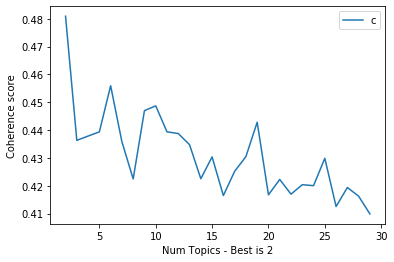

In [24]:
# Create Dictionary
check_reviews = [lst for lst in data_lemmatized if 'knowledgeable' in lst]
id2word = corpora.Dictionary(check_reviews)

# Create Corpus
texts = check_reviews

# Term Document Frequency
check_corpus = [id2word.doc2bow(text) for text in texts]
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=check_corpus, texts=texts, limit=30, start=2, step=1)

# Show graph
limit=30; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
optimal_x = x[coherence_values.index(max(coherence_values))]
plt.xlabel("Num Topics - Best is {}".format(optimal_x))
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=check_corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=1,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(check_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, check_corpus, id2word)
vis


Perplexity:  -6.663344530559169

Coherence Score:  0.4999730926892938


C:\Users\bichn\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.178755  0.0       1        1  86.341766
1     -0.178755  0.0       2        1  13.658237, topic_info=     Category        Freq             Term       Total  loglift  logprob
235   Default   97.000000             food   97.000000  30.0000  30.0000
20    Default  108.000000             city  108.000000  29.0000  29.0000
1     Default  957.000000    knowledgeable  957.000000  28.0000  28.0000
211   Default  109.000000          private  109.000000  27.0000  27.0000
936   Default   45.000000       restaurant   45.000000  26.0000  26.0000
287   Default   50.000000           driver   50.000000  25.0000  25.0000
261   Default   40.000000            night   40.000000  24.0000  24.0000
228   Default   32.000000            local   32.000000  23.0000  23.0000
647   Default  102.000000           family  102.000000  22.0000  22.0000
60    Default  493.000000             time  493.000000  21.0000  21.0000
717   Default   26.000000         vacation   26.000000  20.0000  20.0000
366   Default   25.000000             wine   25.000000  19.0000  19.0000
232   Default   24.000000          evening   24.000000  18.0000  18.0000
127   Default   41.000000        different   41.000000  17.0000  17.0000
1441  Default   34.000000          dungeon   34.000000  16.0000  16.0000
180   Default  260.000000             trip  260.000000  15.0000  15.0000
650   Default   23.000000            hotel   23.000000  14.0000  14.0000
171   Default   25.000000          italian   25.000000  13.0000  13.0000
8     Default  458.000000            great  458.000000  12.0000  12.0000
850   Default   21.000000          culture   21.000000  11.0000  11.0000
299   Default   23.000000             wife   23.000000  10.0000  10.0000
893   Default   34.000000      arena_floor   34.000000   9.0000   9.0000
10    Default   27.000000            level   27.000000   8.0000   8.0000
1049  Default   53.000000             last   53.000000   7.0000   7.0000
24    Default  300.000000            group  300.000000   6.0000   6.0000
434   Default   17.000000            pizza   17.000000   5.0000   5.0000
50    Default  326.000000             good  326.000000   4.0000   4.0000
92    Default  304.000000       experience  304.000000   3.0000   3.0000
574   Default   19.000000              bus   19.000000   2.0000   2.0000
357   Default   16.000000           dinner   16.000000   1.0000   1.0000
...       ...         ...              ...         ...      ...      ...
1111   Topic2    7.643950   transportation    8.288099   1.9099  -6.0888
1452   Topic2    7.019250           dining    7.653353   1.9043  -6.1740
1648   Topic2    8.852726  trastevere_food    9.656508   1.9039  -5.9420
1077   Topic2    8.831532             team    9.651493   1.9020  -5.9444
618    Topic2    8.411993        excursion    9.198905   1.9014  -5.9930
2113   Topic2    4.819808      traditional    5.288093   1.8981  -6.5499
816    Topic2    7.096509         standard    7.807047   1.8954  -6.1631
384    Topic2    4.817605            train    5.330569   1.8896  -6.5504
624    Topic2    9.628902             ship   10.693325   1.8860  -5.8579
175    Topic2   11.457337           mother   12.924730   1.8703  -5.6840
803    Topic2   12.023860        expensive   13.802402   1.8529  -5.6358
20     Topic2   76.547913             city  108.152046   1.6452  -3.7848
287    Topic2   38.565926           driver   50.892132   1.7135  -4.4703
765    Topic2   13.249566             high   15.564214   1.8298  -5.5387
650    Topic2   18.502020            hotel   23.305012   1.7600  -5.2048
773    Topic2   12.790047            water   15.561294   1.7947  -5.5740
574    Topic2   14.951850              bus   19.112358   1.7453  -5.4178
428    Topic2   14.104170             ruin   17.810379   1.7575  -5.4762
850    Topic2   15.288638          culture   21.066368   1.6703  -5.3956
211    Topic2   41.830505          pri